# Codenation Challenge

Autor: Yury Antony Barros

Nessa resolução serão usados três algoritmos de machine learning: **LinearRegressor**,  **KNeighborsRegressor** e **RandomForestRegressor**. Os modelos com melhor desempenho serão usados para fazer a previsão do resultado final.

In [1]:
#bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

## Conhecendo os dados

In [2]:
data = pd.read_csv('assets/train.csv')
answer = pd.read_csv('assets/test.csv')

O desafio disponibiliza dois datasets, um para fazer o treinamento (data) e outro para fazer as previsões (answer)

In [3]:
#verificando se os datasets possuem as mesmas classes de entrada
comparador = data
comparador = comparador.drop('NU_NOTA_MT',axis=1) #o dataset answer por definição não tem essa coluna, por isso ela é removida
verifica = set(comparador.columns).issubset(set(answer.columns))
if verifica:
    print('Datasets possuem as mesmas colunas - Saida:', verifica)
else:
    print('Datasets não possuem as mesmas colunas - Saida:', verifica)

Datasets não possuem as mesmas colunas - Saida: False


In [4]:
#Uma vez constatado que o Dataset answer não possue as mesmas classes do dataset de treinamento
#faz-se a verificação de quais classes ele possue.

print('CLASSES DO DATASET (answer):')
colunas = answer.columns
leng,step = len(colunas)-3,3
for i in range(0,leng,step):  
    print(colunas[i],'--',colunas[i+1],'--',colunas[i+2])

CLASSES DO DATASET (answer):
NU_INSCRICAO -- CO_UF_RESIDENCIA -- SG_UF_RESIDENCIA
NU_IDADE -- TP_SEXO -- TP_COR_RACA
TP_NACIONALIDADE -- TP_ST_CONCLUSAO -- TP_ANO_CONCLUIU
TP_ESCOLA -- TP_ENSINO -- IN_TREINEIRO
TP_DEPENDENCIA_ADM_ESC -- IN_BAIXA_VISAO -- IN_CEGUEIRA
IN_SURDEZ -- IN_DISLEXIA -- IN_DISCALCULIA
IN_SABATISTA -- IN_GESTANTE -- IN_IDOSO
TP_PRESENCA_CN -- TP_PRESENCA_CH -- TP_PRESENCA_LC
CO_PROVA_CN -- CO_PROVA_CH -- CO_PROVA_LC
CO_PROVA_MT -- NU_NOTA_CN -- NU_NOTA_CH
NU_NOTA_LC -- TP_LINGUA -- TP_STATUS_REDACAO
NU_NOTA_COMP1 -- NU_NOTA_COMP2 -- NU_NOTA_COMP3
NU_NOTA_COMP4 -- NU_NOTA_COMP5 -- NU_NOTA_REDACAO
Q001 -- Q002 -- Q006
Q024 -- Q025 -- Q026


In [5]:
#Verificando qual nota de competencia tem mais correlação com a nota de matematica
# esse dado será usado para auxiliar na previsão de média posteriormente
var = ['NU_NOTA_MT','NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5']
data[var].corr()

,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
NU_NOTA_MT,1.000000,0.299402,0.335638,0.350307,0.342282,0.343337
NU_NOTA_COMP1,0.299402,1.000000,0.756664,0.759452,0.824538,0.558587
NU_NOTA_COMP2,0.335638,0.756664,1.000000,0.875447,0.808006,0.655915
NU_NOTA_COMP3,0.350307,0.759452,0.875447,1.000000,0.827151,0.664350
NU_NOTA_COMP4,0.342282,0.824538,0.808006,0.827151,1.000000,0.635018
NU_NOTA_COMP5,0.343337,0.558587,0.655915,0.664350,0.635018,1.000000


A nota de competencia 3 ['NU_NOTA_COMP3'] é a que mais tem correlação com a nota de matematica, ela será usada com os dados de entrada

## Tratando os dados

##### Separando dados relevantes para o problema

In [6]:
novo = {
    'matematica': data['NU_NOTA_MT'],
    'ciencias_n': data['NU_NOTA_CN'],
    'linguagens': data['NU_NOTA_LC'],
    'ciencias_h': data['NU_NOTA_CH'],
    'redacao': data['NU_NOTA_REDACAO'],
    'nota_comp3': data['NU_NOTA_COMP3']
}


data = pd.DataFrame(novo)


#Removendo elementos com dados faltantes
data = data.dropna(axis=0, how='any')


data.head(1)

,matematica,ciencias_n,linguagens,ciencias_h,redacao,nota_comp3
0,399.4,436.3,581.2,495.4,520.0,120.0


##### Definindo Fuções para auxilo

In [7]:
#Definindo uma função para criar uma nova coluna com a media das notas

def media(n1,n2,n3,n4,n5):
    m = []
    for i in range(len(n1)):
        result = n1[i]+n2[i]+n3[i]+n4[i]+n5[i]/5
        m.append(result)
    return m



#Definindo função para plotar grafico de comparação
def grafico(previsto,real,nome):
    previsto = np.array(previsto)
    real = np.array(real)
    
    mape = mean_absolute_error(real,previsto)
    
    y1 = previsto[:50]
    x1 = range(len(y1))
    y2 = real[:50]
    x2 = range(len(y2))
    

    plt.title('Gráfico de Predições:'+nome)
    plt.xlabel('mape: '+str(mape))
    plt.ylabel('Valores')

    plt.plot(x1,y1,color='#D90286',linestyle='--',label='Predita')
    plt.plot(x2,y2,color='#0864AD',linestyle='-.', label = 'Esperada')
    plt.legend()
    plt.show()

#Definindo função para normalizar os dados
def normalize_on(data):
    data = data/100
    return data
#Definindo função para retornar os dados que foram normalizados
def normalize_off(data):
    data = data*100
    return data

#Definindo função para plotar grafico de comparação
def  grafico_mape(xy1,xy2,xy3,title):
    plt.suptitle('Média percentual do desvio absoluto (MAPE)')
    plt.title(title)
    plt.ylabel('MAPE')
    plt.xlabel('Menor erro = Melhor desempenho')

    plt.bar(xy1[0],xy1[1])
    plt.bar(xy2[0],xy2[1])
    plt.bar(xy3[0],xy3[1])
    plt.show()

tst_size = 0.10

In [8]:
#adicionando a coluna 'media'
data['media'] = media(np.array(data.matematica),np.array(data.ciencias_n),np.array(data.linguagens),np.array(data.ciencias_h),np.array(data.redacao))
data.head()

,matematica,ciencias_n,linguagens,ciencias_h,redacao,nota_comp3,media
0,399.4,436.3,581.2,495.4,520.0,120.0,2016.3
1,459.8,474.5,599.0,544.1,580.0,120.0,2193.4
5,364.5,439.7,410.9,583.2,620.0,120.0,1922.3
6,529.2,420.1,484.5,604.2,560.0,120.0,2150.0
7,566.7,619.6,611.2,625.8,620.0,120.0,2547.3


##### Normalizando dados

In [9]:
# Para aumentar a eficácia do algoritmo é recomendado fazer a normalização dos dados
#Normalização é utilizar uma função para alterar os dados de forma proporcional
# a função é de escolha pessoal e vem atráves do reconhecimento dos dados através da anlálise
# neste caso a função normalize_on() divide todos os dados por 100, afim de diminuir a escala 
#e melhorar o desempenho dos modelos 

new = data #coloando o dataset em outra variável para evitar que a função sobrecarregue os dados
#obs: executar essa celula depois de executar a celula a baixo, pode sobrecarregar os dados com a função

In [10]:
data = normalize_on(new)
data.head()

,matematica,ciencias_n,linguagens,ciencias_h,redacao,nota_comp3,media
0,3.994,4.363,5.812,4.954,5.2,1.2,20.163
1,4.598,4.745,5.990,5.441,5.8,1.2,21.934
5,3.645,4.397,4.109,5.832,6.2,1.2,19.223
6,5.292,4.201,4.845,6.042,5.6,1.2,21.500
7,5.667,6.196,6.112,6.258,6.2,1.2,25.473


# Modelos de Treinamento

## Regressão Linear

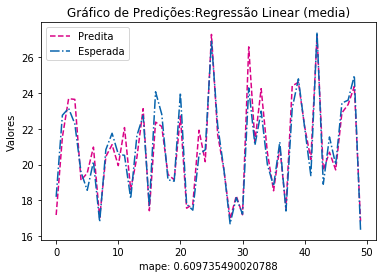

In [11]:
#separando dados de entrada(x) e saida(y)
y = data['media']
x = data
x = x.drop(['matematica','media'],axis=1)

#split de dados
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y, test_size=tst_size)

#treinando media, sem as notas de matematica
RL = LinearRegression()
RL.fit(x_treino,y_treino)
prever = RL.predict(x_teste)
modelo1_media = ['LinearRegression',mean_absolute_error(y_teste,prever)]

#imprimindo predições
grafico(prever,y_teste,'Regressão Linear (media)')

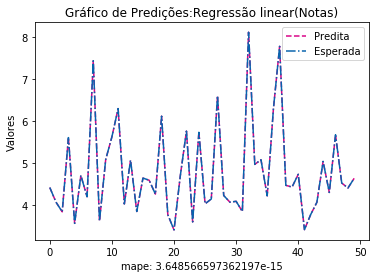

In [12]:
#separando dados de entrada(x) e saida(y)
y = data['matematica']
x = data

x = x.drop(['matematica'],axis=1)

#split de dados
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=tst_size)

#treinando notas de matematica, cem os dados de media
RL2 = LinearRegression()
RL2.fit(x_treino,y_treino)
prever = RL2.predict(x_teste)
modelo1_nota = ['LinearRegression',mean_absolute_error(y_teste,prever)]

#imprimindo predições
grafico(prever,y_teste,'Regressão linear(Notas)')

## k Nearest Neighbor (KNN)

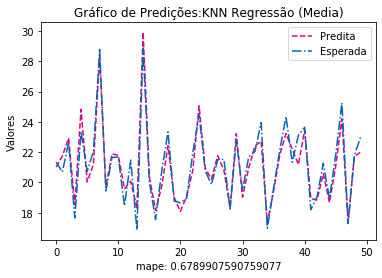

In [13]:
#separando dados de entrada(x) e saida(y)
y = data['media']
x = data

x = x.drop(['matematica','media'],axis=1)

#split de dados
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y, test_size=tst_size)

#treinando media com knn, sem os dados de matematica
knn = KNeighborsRegressor(n_neighbors = 3, p = 1)
knn.fit(x_treino,y_treino)
prever = knn.predict(x_teste)
modelo2_media = ['KNN',mean_absolute_error(y_teste,prever)]

#imprimindo predições
grafico(prever,y_teste,'KNN Regressão (Media)')

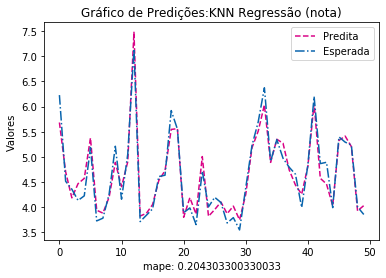

In [14]:
#separando dados de entrada(x) e saida(y)
y = data['matematica']
x = data

x = x.drop(['matematica'],axis=1)

#split de dados
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=tst_size)

#treinando notas de matematica, sem os dados de media
knn2 = KNeighborsRegressor(n_neighbors = 3, p = 1)
knn2.fit(x_treino,y_treino)
prever = knn2.predict(x_teste)
modelo2_nota = ['KNN',mean_absolute_error(y_teste,prever)]

#imprimindo predições
grafico(prever,y_teste,'KNN Regressão (nota)')

# Random Forest

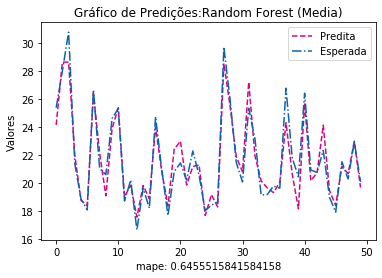

In [15]:
#separando dados de entrada(x) e saida(y)
y = data['media']
x = data

x = x.drop(['matematica','media'],axis=1)

#split de dados
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y, test_size=tst_size)

#treinando media com knn, sem os dados de matematica
RF = RandomForestRegressor(n_estimators= 50)
RF.fit(x_treino,y_treino)
prever = RF.predict(x_teste)
modelo3_media = ['RandomForest',mean_absolute_error(y_teste,prever)]

#imprimindo predições
grafico(prever,y_teste,'Random Forest (Media)')

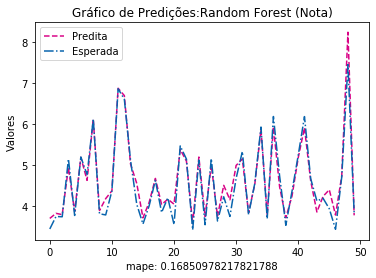

In [16]:
#separando dados de entrada(x) e saida(y)
y = data['matematica']
x = data

x = x.drop(['matematica'],axis=1)

#split de dados
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=tst_size)

#treinando notas de matematica, sem os dados de media
RF2 = RandomForestRegressor(n_estimators= 50)
RF2.fit(x_treino,y_treino)
prever = RF2.predict(x_teste)
modelo3_nota = ['RandomForest',mean_absolute_error(y_teste,prever)]

#imprimindo predições
grafico(prever,y_teste,'Random Forest (Nota)')

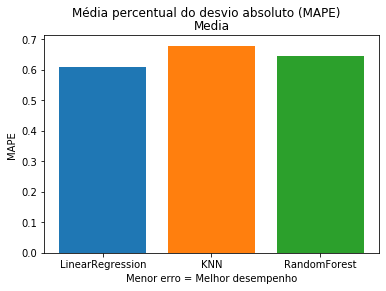

In [17]:
grafico_mape(modelo1_media,modelo2_media,modelo3_media,'Media')

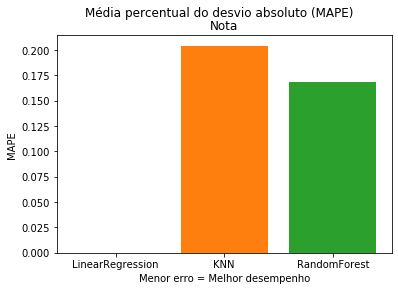

In [18]:
grafico_mape(modelo1_nota,modelo2_nota,modelo3_nota,'Nota')

Nessa leitura o modelo **LinearRegression** teve seu erro muito elevado em comparação aos outros modelos, por isso ele não foi reconhecido na representação gráfica

# Tratando dados da resposta

In [19]:
novo = {
    'ciencias_n': answer['NU_NOTA_CN'],
    'linguagens': answer['NU_NOTA_LC'],
    'ciencias_h': answer['NU_NOTA_CH'],
    'redacao': answer['NU_NOTA_REDACAO'],
     'nota_comp3': answer['NU_NOTA_COMP3']
}


dados = pd.DataFrame(novo)


#Removendo elementos com dados faltantes
dados = dados.dropna(axis=0, how='any')

#normalizando dados
dados = normalize_on(dados)

dados.head(1)

,ciencias_n,linguagens,ciencias_h,redacao,nota_comp3
0,4.648,4.318,4.435,4.2,0.8


In [20]:
#Recebendo predicoes de media para o dataset de respostas
respostas = RF.predict(dados)
dados['media'] = respostas
dados.head(1)

,ciencias_n,linguagens,ciencias_h,redacao,nota_comp3,media
0,4.648,4.318,4.435,4.2,0.8,18.34062


In [21]:
#Recebendo predicoes de notas de matematica
respostas = RF2.predict(dados)
dados['matematica'] = respostas
dados.head()

,ciencias_n,linguagens,ciencias_h,redacao,nota_comp3,media,matematica
0,4.648,4.318,4.435,4.2,0.8,18.34062,4.02744
1,3.911,5.480,4.911,5.8,1.2,19.75456,4.31882
2,5.959,6.136,6.227,3.2,0.4,25.41786,6.09840
4,5.929,5.714,4.926,3.2,0.6,22.94340,5.33564
5,4.145,5.425,5.685,5.6,1.2,20.95494,4.58640


In [22]:
#removendo a normalização dos dados de matematica

dados['matematica'] = normalize_off(dados['matematica'])
dados.head()

,ciencias_n,linguagens,ciencias_h,redacao,nota_comp3,media,matematica
0,4.648,4.318,4.435,4.2,0.8,18.34062,402.744
1,3.911,5.480,4.911,5.8,1.2,19.75456,431.882
2,5.959,6.136,6.227,3.2,0.4,25.41786,609.840
4,5.929,5.714,4.926,3.2,0.6,22.94340,533.564
5,4.145,5.425,5.685,5.6,1.2,20.95494,458.640


In [23]:
#tratamento final de dados
dados = dados.drop(['ciencias_n','linguagens','ciencias_h','redacao','nota_comp3'],axis=1)
dados['NU_INSCRICAO'] =  answer['NU_INSCRICAO']
dados['NU_NOTA_MT'] = dados['matematica']
dados = dados.drop(['matematica'],axis=1)
dados = dados.drop(['media'],axis=1)
dados['NU_NOTA_MT'] = dados['NU_NOTA_MT']

In [24]:
# transformando dataser de respostas em um arquivo CSV
dados.to_csv('answer.csv',index=False)

In [25]:
#abrindo Arquivo CSV
final = pd.read_csv('answer.csv')
final.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,402.744
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,431.882
2,b38a03232f43b11c9d0788abaf060f7366053b6d,609.840
3,715494628a50142ce8cb17191cfe6d0f3cae0934,533.564
4,e656d6bad65c93fb2880f1eba5037008c8e75774,458.640
